# 3. Продуктовые гипотезы

Нашей командой принято решение также проанализировать 2 продуктовые гипотезы.

GA Sessions
Одна строка = один визит на сайт.
Описание атрибутов:
~ session_id — ID визита;
~ client_id — ID посетителя;
~ visit_date — дата визита;
~ visit_time — время визита;
~ visit_number — порядковый номер визита клиента;
~ utm_source — канал привлечения;
~ utm_medium — тип привлечения;
~ utm_campaign — рекламная кампания;
~ utm_keyword — ключевое слово;
~ device_category — тип устройства;
~ device_os — ОС устройства;
~ device_brand — марка устройства;
~ device_model — модель устройства;
~ device_screen_resolution — разрешение экрана;
~ device_browser — браузер;
~ eo_country — страна;
~ geo_city — город.

GA Hits
Одна строка = одно событие в рамках одного визита на сайт.
Описание атрибутов:
~ session_id — ID визита;
~ hit_date — дата события;
~ hit_time — время события;
~ hit_number — порядковый номер события в рамках сессии;
~ hit_type — тип события;
~ hit_referer — источник события;
~ hit_page_path — страница события;
~ event_category — тип действия;
~ event_action — действие;
~ event_label — тег действия;
~ event_value — значение результата действия.

In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gah = pd.read_csv('ga_hits.csv', low_memory=False)
gas = pd.read_csv('ga_sessions.csv', low_memory=False)

In [3]:
# для тестирования возьмём эти действия
target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
          'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
          'sub_submit_success', 'sub_car_request_submit_click']

In [4]:
gas.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

Во многих столбцах есть пропуски, мы их заполним как '(not set)', так как по каким-либо причинам они могут быть неизвестны. Например, причины для определения операционной системы могут быть такими:

    - не удалось определить ОС (например, браузеры в режиме инкогнито, блокировка трекеров)

    - технические ошибки при сборе данных

In [5]:
columns_to_exclude = ['visit_date', 'visit_time', 'visit_number', 'target'] # список столбцов, которые нужно оставить без изменений
columns_to_convert = [col for col in gas.columns if col not in columns_to_exclude] # список столбцов, которые нужно преобразовать
for col in columns_to_convert:
    # Заполняем пропуски значением '(not set)'
    gas[col] = gas[col].fillna('(not set)')

In [6]:
# объединим visit_date и visit_time и приведём к типу datetime, колонку visit_time после этого удалим
gas['visit_date'] = pd.to_datetime(gas['visit_date'] + ' ' + gas['visit_time'])
gas = gas.drop(columns=['visit_time'])

In [7]:
gas['hour'] = gas['visit_date'].dt.hour

In [8]:
# Объединяем датасеты для последующего анализа
data = gas.merge(gah, on="session_id", how="left")

# Создание нового столбца, определяющий конверсию
data["is_conversion"] = data['event_action'].isin(target_actions).astype(int)
data.head()

,session_id,client_id,visit_date,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,...,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,is_conversion
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,3665.0,3.0,event,NaN,podpiska.sberauto.com/,sub_page_view,sub_landing,NaN,NaN,0
1,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,46592.0,4.0,event,NaN,podpiska.sberauto.com/,sub_button_click,sub_view_cars_click,vodKSlUobUWTVlgsJqdI,NaN,0
2,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,...,921.0,3.0,event,NaN,podpiska.sberauto.com/,sub_page_view,sub_landing,NaN,NaN,0
3,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,84155.0,10.0,event,NaN,sberauto.com/cars?utm_source_initial=sbol&utm_...,search_form,search_form_region,KWTCzSIXzoqUWjfUQMgP,NaN,0
4,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,...,102979.0,13.0,event,NaN,sberauto.com/cars?utm_source_initial=sbol&utm_...,search_form,search_form_region,CBqnBQaKoQUyWJhLcxxN,NaN,0


In [9]:
# Посмотрим часто встречающиеся OS
print(data["device_os"].value_counts())

device_os
(not set)        9215059
Android          3472049
iOS              1760463
Windows          1022091
Macintosh         311143
Linux              31436
Chrome OS            378
BlackBerry           214
Tizen                 99
Firefox OS            37
Nokia                 13
Windows Phone          9
Samsung                4
Name: count, dtype: int64


ОС вроде Tizen, Firefox OS, BlackBerry и Nokia встречаются редко → малая выборка для анализа. Поэтому было принято решение объединить их в одну группу "Other_OS".

In [10]:
rare_os = ['Tizen', 'Firefox OS', 'BlackBerry', 'Nokia', 'Windows Phone', 'Samsung', 'Chrome OS']
data['device_os_grouped'] = data['device_os'].apply(lambda x: x if x not in rare_os else 'Other_OS')

# Теперь посмотрим какую долю занимают ОС
os_distribution = data['device_os_grouped'].value_counts(normalize=True) * 100
print(os_distribution)

device_os_grouped
(not set)    58.275229
Android      21.956935
iOS          11.133014
Windows       6.463614
Macintosh     1.967641
Linux         0.198799
Other_OS      0.004768
Name: proportion, dtype: float64


Самые часто встречающиеся ОС - Android и iOS.

In [11]:
# Группировка по session_id и device_os
conversion_data = data.groupby(["session_id", "device_os_grouped"]).agg(
    is_conversion=("is_conversion", "max")  # 1, если в сессии было целевое действие
).reset_index()

Conversation Rate/CR — доля визитов, в которых было совершено хотя бы одно целевое действие. Теперь рассчитаем для каждой операционной системы её CR.

In [12]:
cr_by_os = conversion_data.groupby("device_os_grouped").agg(
    total_sessions=("session_id", "nunique"),
    conversions=("is_conversion", "sum")
).reset_index()

cr_by_os["CR"] = cr_by_os["conversions"] / cr_by_os["total_sessions"] * 100
display(cr_by_os)

,device_os_grouped,total_sessions,conversions,CR
0,(not set),1070502,34437,3.216902
1,Android,464054,9463,2.039202
2,Linux,5120,90,1.757812
3,Macintosh,24824,772,3.109894
4,Other_OS,131,0,0.000000
5,Windows,88307,1633,1.849231
6,iOS,207104,3919,1.892286


Интересно, что хотя iOS и Android имеют низкий CR, Macintosh и "(not set)" показывают более высокую конверсию.

# 3.1 Постановка гипотезы 1

**Гипотеза 1:** Пользователи с операционной системой Macintosh и сессиями с неопределенной ОС (not set) конвертируются чаще, потому что они:

1. Чаще используют десктопные устройства (Mac), где сайт лучше адаптирован для больших экранов, а пользователи детальнее изучают условия аренды.

2. Сегмент (not set) может включать трафик из платных каналов (например, email-рассылки), где аудитория уже заинтересована в услуге.

Для проверки влияние операционной системы на конверсию используем A/B-тест (хи-квадрат) для таблицы сопряженностей.
 - Нулевая гипотеза: Операционная система и конверсии (совершения целевого действия) независимы.
 - Альтернативная гипотеза: Операционная система влияет на совершение целевого действия

In [13]:
# Составляем матрицу сопряженности (первый столбец - конверсия, второй - неконверсия)
observed = [[34437, 1070502-34437], # (not set)
            [3919, 207104-3919],  # iOS
            [9463, 464054-9463], # Android
            [90, 5120-90], # Linux
            [772, 24824-772], # Macintosh
            [1633, 88307-1633], # Windows
            [0, 131-0]] # Other OS
# Взяли общепринятый уровень значимости для проверки гипотезы
alpha = 0.05

# Расчёт p-value и статистики chi2
chi2, p_value, _, _ = chi2_contingency(observed)
print(f"Нулевая гипотеза: {"отвергается" if p_value < alpha else "не отвергается"}")

Нулевая гипотеза: отвергается


Так как нулевая гипотеза отвергается, делаем вывод, что операционная система сильно влияет на конверсию.

# 3.2 Анализ для "(not set)"


**Цель:** Выяснить, кто скрывается за этим сегментом и почему их CR выше среднего.

Для начала проверим влияние email рассылки на конверсию.
- Нулевая гипотеза: email и конверсии (совершения целевого действия) независимы.
 - Альтернативная гипотеза: email влияет на совершение целевого действия

In [14]:
# Анализируем из каких типов привлецения (utm_medium) приходит трафик с (not set)
not_set_data = data[data['device_os_grouped'] == '(not set)']
not_set_medium = not_set_data.groupby('utm_medium').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()

top_medium = not_set_medium.sort_values('cr', ascending=False).head(3)
display(top_medium)

not_set_medium_email = not_set_medium[not_set_medium['utm_medium'] == "email"][["total_sessions", "conversions"]]
not_set_medium_not_email = not_set_medium[not_set_medium['utm_medium'] != "email"][["total_sessions", "conversions"]].sum(axis=0)

,utm_medium,total_sessions,conversions,cr
18,link,45,86,0.267913
16,landing,116,42,0.048331
1,(not set),202,73,0.035784


In [15]:
# Составляем матрицу сопряженности (первый столбец - конверсия, второй - неконверсия)
observed = [[not_set_medium_email.values[0][1], not_set_medium_email.values[0][0]-not_set_medium_email.values[0][1]], # email
            [not_set_medium_not_email.values[1], not_set_medium_not_email.values[0]-not_set_medium_not_email.values[1]]]  # not email
# Взяли общепринятый уровень значимости для проверки гипотезы
alpha = 0.05

# Расчёт p-value и статистики chi2
chi2, p_value, _, _ = chi2_contingency(observed)
print(f"Нулевая гипотеза: {"отвергается" if p_value < alpha else "не отвергается"}")

Нулевая гипотеза: отвергается


Гипотеза отвергается, следовательно, привлечение по email влияет на конверсию, хотя у нее не самый высокий CR. Далее выясним, по какому источнику чаще конверсируются с неопределённой операционной системой.

In [16]:
# Анализируем из каких каналов (utm_source, utm_medium) приходит трафик с (not set)
not_set_sources = not_set_data.groupby('utm_source').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()
display(not_set_sources)

,utm_source,total_sessions,conversions,cr
0,ANoZJgYuPrWNkAAchryx,9,0,0.000000
1,BHcvLfOaCWvWTykYqHVe,78649,5544,0.007081
2,BKeImrJuRDZcHiSSTdzm,1418,178,0.011700
3,BTOBxRcZAuMDAGcpupRx,1,0,0.000000
4,BellrslNBZQZaIxVFGXJ,1,0,0.000000
...,...,...,...,...
186,ySpKPVDYCgmkHVSeLjnJ,29,3,0.010989
187,yfjcpPqMeNcSIiswGTeQ,2,0,0.000000
188,yxJKymlSGVuKIPTxbysx,3,1,0.100000
189,zGUBrOvMRpLqBkJPUsYo,2,0,0.000000


Большинство utm_source имеют мало сессий (1–10), что делает их CR ненадежным.

In [17]:
# Отфильтруем сессии больше 100 и выделим топ-3 с самым высоким CR
filtered_not_set_sources = not_set_sources[not_set_sources['total_sessions'] >= 100]
top_sources = filtered_not_set_sources.sort_values('cr', ascending=False).head(3)
display(top_sources)

,utm_source,total_sessions,conversions,cr
158,oZCzWSykfixnjMPDNjSU,2198,410,0.017407
153,ngkgBNjlzLYBofkljaBo,174,7,0.013972
113,azajeHUvPOKkHBvWFbjz,105,8,0.012739


Источник oZCzWSykfixnjMPDNjSU перспективен для более глубокого анализа.

Гипотеза: Источник oZCzWSykfixnjMPDNjSU эффективен из-за релевантного трафика (например, таргетинг на аудиторию, заинтересованную в долгосрочной аренде).
Для этого нужно:
1. узнать, что это за канал.
2. сравнить поведение пользователей из этого источника с другими (по глубине просмотра (hit_number))



In [35]:
# Определим целевой utm_source
TARGET_SOURCE = 'oZCzWSykfixnjMPDNjSU'

medium = not_set_data[not_set_data['utm_source'] == 'oZCzWSykfixnjMPDNjSU']["utm_medium"].unique()
print(f"Тип(ы) привлечения у источника: {medium}")

# Фильтрация данных
target_data = data[data['utm_source'] == TARGET_SOURCE]
control_data = data[data['utm_source'] != TARGET_SOURCE]

# Глубина просмотра (макс hit_number в сессии)
target_depth = target_data.groupby('session_id')['hit_number'].max().dropna()
control_depth = control_data.groupby('session_id')['hit_number'].max().dropna()

Тип(ы) привлечения у источника: ['referral']


Распределения целевой группы и контрольной будем сравнивать по критерию Манна-Уитни.
 - Нулевая гипотеза: распределения одинаковы
  - Альтернативная гипотеза: распределения различны

In [36]:
# Определим функцию, которая будет сравнивать распределения метрик по Манна-Уитни критерию
def compare_metrics(metric_name, target_metric, control_metric):
    print(f'\n--- {metric_name} ---')
    print(f'Target (n={len(target_metric)}): Мат. ожидание = {np.mean(target_metric):.1f}')
    print(f'Control (n={len(control_metric)}): Мат. ожидание = {np.mean(control_metric):.1f}')

    # Тест Манна-Уитни для непрерывных метрик
    stat, p = mannwhitneyu(target_metric, control_metric, alternative='two-sided')
    print(f'U-test: p-value = {p:.4f}')

In [37]:
compare_metrics('Глубина просмотра', target_depth, control_depth)


--- Глубина просмотра ---
Target (n=1893): Мат. ожидание = 17.7
Control (n=1012380): Мат. ожидание = 14.5
U-test: p-value = 0.0000


Видим, что тип привлечения у источника это реферальная ссылка. Для глубины посещения критерий показывает, что наш целевой источник значительно влияет на глубину просмотра. В среднем благодаря этому источнику на 3 события больше в сессии. Пользователи из этого источника проявляют более высокую вовлеченность.


Первоначальная гипотеза предполагала, что высокая конверсия в сегменте (not set) связана с платными каналами (email). Однако анализ показал:

Email имеет статистически значимый CR, но он не максимальный.

Самый высокий CR наблюдается у реферального трафика (referral) и типа link, которые не относятся к платным каналам.

**Вывод:**
Гипотеза о том, что (not set) включает преимущественно платные каналы с заинтересованной аудиторией (гипотеза 1 (пункт 2)), не подтверждается. Основной драйвер конверсии — реферальный трафик и другие источники.



# 3.3 Aнализ Macintosh

**Цель:** Понять, почему пользователи Mac конвертируются лучше.

,device_category,total_sessions,conversions,cr
0,desktop,24804,2774,0.008916
1,mobile,10,0,0.000000
2,tablet,10,0,0.000000


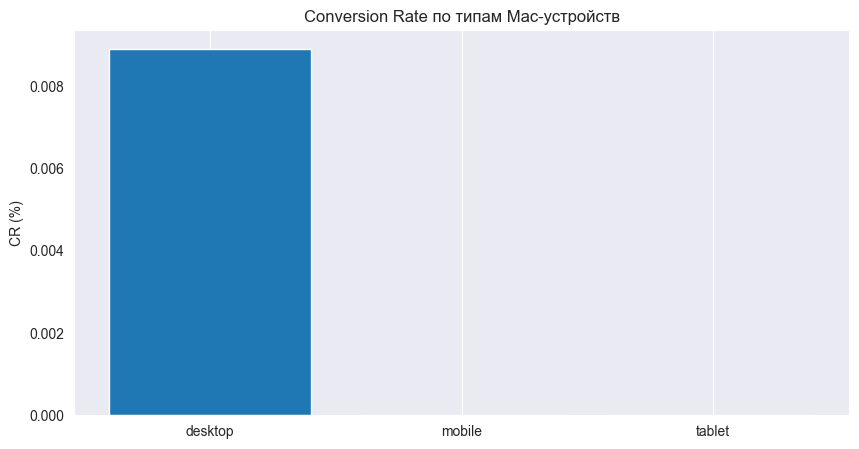

In [21]:
mac_data = data[data['device_os_grouped'] == 'Macintosh']
mac_device_category = mac_data.groupby("device_category").agg(
    total_sessions=('session_id', 'nunique'),
    conversions=('is_conversion', 'sum'),
    cr=('is_conversion', 'mean')
).reset_index()
display(mac_device_category)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(mac_device_category['device_category'], mac_device_category['cr'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Conversion Rate по типам Mac-устройств')
plt.ylabel('CR (%)')
plt.grid(axis='y')
plt.show()

Странно, что есть телефоны и планшеты с ОС Макинтош. Возможно, это ошибка в данных. Но видно, что все конверсии были сделаны с компьютеров.

In [22]:
# Анализ страниц
page_analysis = mac_data.groupby('hit_page_path').agg(
    page_views=('hit_number', 'count'),
    conversions=('is_conversion', 'sum'),
    cr=('is_conversion', 'mean')
).reset_index()

# Фильтрация и сортировка
top_page_analysis = page_analysis[
    (page_analysis['page_views'] > 100) &  # Исключаем редко посещаемые
    (~page_analysis['hit_page_path'].str.contains('admin|test', na=False))  # Исключаем техстраницы
].sort_values('cr', ascending=False).head(3)
display(top_page_analysis)

,hit_page_path,page_views,conversions,cr
1746,podpiska.sberauto.com/faq,537,75,0.139665
1887,podpiska.sberauto.com/greenday,482,41,0.085062
4609,sberauto.com/cars/all/mercedes-benz/cla-klasse...,903,58,0.064230


По таблице виден топ-3 страницы по целевым действиям.

podpiska.sberauto.com/faq - страница с ответами на частые вопросы, высокий CR может означать, что пользователи находят здесь ключевую информацию, которая стимулирует их к действию.

podpiska.sberauto.com/greenday - возможно, страница с акциями, тогда высокий CR говорит о том, что таргетированные промо-кампании для Mac-аудитории работают.

sberauto.com/cars/all/mercedes-benz/cla-klasse... - страница определённой модели машины. Пользователи Mac чаще конвертируются на страницах с детальными описаниями и фото.

**Вывод:**

Гипотеза 1 (пункт 1) подтверждена:

- Mac-десктопы — ключевой сегмент с высокой конверсией благодаря удобству интерфейса.

- Страницы с детальной информацией (FAQ, каталог) играют решающую роль в принятии решения.

Теперь рассмотрим конверсию в зависимости от города.

In [24]:
# Теперь посмотрим какую долю занимают города
city_distribution = data['geo_city'].value_counts(normalize=True) * 100
print(city_distribution)

geo_city
Moscow                    43.315760
Saint Petersburg          15.075613
(not set)                  3.801645
Yekaterinburg              2.090268
Krasnodar                  1.868615
                            ...    
Odense                     0.000006
Pak Chong                  0.000006
Riccione                   0.000006
Rheda-Wiedenbruck          0.000006
Lorenskog Municipality     0.000006
Name: proportion, Length: 2548, dtype: float64


Оставим 2 города: Москву и Питер, остальные объединим в "Other cities"

In [26]:
data["geo_city"] = data["geo_city"].apply(lambda x: x if (x == "Moscow") | (x == "Saint Petersburg") else "Other cities")
print(data["geo_city"].unique())

['Other cities' 'Moscow' 'Saint Petersburg']


In [29]:
# Группировка по session_id и geo_city
conversion_data_new = data.groupby(["session_id", "geo_city"]).agg(
    is_conversion=("is_conversion", "max")  # 1, если в сессии было целевое действие
).reset_index()

cr_by_сity = conversion_data_new.groupby("geo_city").agg(
    total_sessions=("session_id", "nunique"),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()
cr_by_сity

,geo_city,total_sessions,conversions,cr
0,Moscow,805329,23629,0.029341
1,Other cities,757925,19572,0.025823
2,Saint Petersburg,296788,7113,0.023967


Видно, что наибольший CR в Москве.

# 3.4 Постановка гипотезы 2

**Гипотеза 2:** Пользователи из Москвы конвертируются на 14% чаще, чем из других городов. Это может быть связано с:

1. Более агрессивным маркетингом в столице (например, локальные рекламные кампании, спецпредложения для Москвы).

2. Особенности аудитории: жители Москвы чаще конвертируются, так как больше проводят времени на сайте и чаще возвращаются.

Для начала проверим наличие влияния города на конверсию с помощью теста хи-квадрат.
 - Нулевая гипотеза: Город и конверсии (совершения целевого действия) независимы.
 - Альтернативная гипотеза: Город влияет на совершение целевого действия

In [32]:
# Составляем матрицу сопряженности (первый столбец - конверсия, второй - неконверсия)
observed = [[cr_by_сity.values[0][2], cr_by_сity.values[0][1]-cr_by_сity.values[0][2]], # Moscow
            [cr_by_сity.values[1][2], cr_by_сity.values[1][1]-cr_by_сity.values[1][2]], # Other cities
            [cr_by_сity.values[2][2], cr_by_сity.values[2][1]-cr_by_сity.values[2][2]]]  # Saint Petersburg
# Взяли общепринятый уровень значимости для проверки гипотезы
alpha = 0.05

# Расчёт p-value и статистики chi2
chi2, p_value, _, _ = chi2_contingency(observed)
print(f"Нулевая гипотеза: {"отвергается" if p_value < alpha else "не отвергается"}")

Нулевая гипотеза: отвергается


Нулевая гипотеза отвергается в пользу альтернативной, следовательно, делаем вывод, что город влияет на совершенное действие.

# 3.5 Анализ маркетинга в Москве

Для начала рекламные кампании.

In [42]:
moscow_data = data[data['geo_city'] == 'Moscow']

# Анализируем из каких каналов (utm_campaign) приходит трафик с Moscow
moscow_campaigns = moscow_data.groupby('utm_campaign').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()
display(moscow_campaigns)

,utm_campaign,total_sessions,conversions,cr
0,(not set),121411,10751,0.008367
1,AqudXfUnmXWSDWVGYaXr,1274,4,0.001354
2,BAZCuyHZnaPrMGOMrcCQ,223,0,0.000000
3,BHcvLfOaCWvWTykYqHVe,1,0,0.000000
4,BHqsCPwtnpaQSryaVXya,7,0,0.000000
...,...,...,...,...
358,zeAhgziIlupwjQfwRisw,40,0,0.000000
359,zfwIehuEfWYdYrEZgRLo,254,5,0.002589
360,zmnpxOKDENholtspXiGy,364,0,0.000000
361,zxoiLxhuSIFrCeTLQVWZ,3027,175,0.005581


In [43]:
# Отфильтруем сессии больше 100 и выделим топ-3 с самым высоким CR
filtered_moscow_campaigns = moscow_campaigns[moscow_campaigns['total_sessions'] >= 100]
top_campaigns = filtered_moscow_campaigns.sort_values('cr', ascending=False).head(3)
display(top_campaigns)

,utm_campaign,total_sessions,conversions,cr
232,hJvOVTMdhkqIBqjVrsOL,257,85,0.126866
63,KCcrgoFqYxCpSjdRyJjZ,123,47,0.051143
215,emlBaVkgLVRqbEVOSSXt,598,246,0.040871


Кампания hJvOVTMdhkqIBqjVrsOL имеет самый высокий CR, посмотрим какой тип привлечения у неё.

In [45]:
medium = moscow_data[moscow_data['utm_campaign'] == "hJvOVTMdhkqIBqjVrsOL"]["utm_medium"].unique()
print(f"Тип(ы) привлечения у рекламной компании: {medium}")

Тип(ы) привлечения у рекламной компании: ['cpc' 'referral']


Теперь будем анализировать источники.

In [33]:
# Анализируем из каких каналов (utm_source) приходит трафик с Moscow
moscow_sources = moscow_data.groupby('utm_source').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()
display(moscow_sources)

,utm_source,total_sessions,conversions,cr
0,(not set),60,7,0.013109
1,AHgbtEjTEsiUMJouiDYS,5,0,0.000000
2,ANoZJgYuPrWNkAAchryx,7,0,0.000000
3,ArbfvYgWhqxkzywKqpQf,6,0,0.000000
4,AuJjYKxJakEqFnCmyFtz,4,0,0.000000
...,...,...,...,...
216,yxJKymlSGVuKIPTxbysx,3,1,0.100000
217,zPJpddwzkFqLMSYgtDqy,1,0,0.000000
218,zhqxcsahQYAzJvRzebNp,22,1,0.012987
219,zslzdtckVsyxcYqKBRRn,1,0,0.000000


In [34]:
# Отфильтруем сессии больше 100 и выделим топ-3 с самым высоким CR
filtered_moscow_sources = moscow_sources[moscow_sources['total_sessions'] >= 100]
top_sources = filtered_moscow_sources.sort_values('cr', ascending=False).head(3)
display(top_sources)

,utm_source,total_sessions,conversions,cr
220,zwpKjjsMoRVCdipntaHt,158,18,0.030050
185,oZCzWSykfixnjMPDNjSU,1771,287,0.018432
40,IZEXUFLARCUMynmHNBGo,1749,268,0.014306


Источник zwpKjjsMoRVCdipntaHt перспективен для более глубокого анализа.

Гипотеза: Источник zwpKjjsMoRVCdipntaHt эффективен из-за релевантного трафика (например, таргетинг на аудиторию, заинтересованную в долгосрочной аренде).
Для этого нужно:
1. узнать, что это за канал.
2. сравнить поведение пользователей из этого источника с другими (по глубине просмотра (hit_number))

In [38]:
# Определим целевой utm_source
TARGET_SOURCE = 'zwpKjjsMoRVCdipntaHt'

medium = moscow_data[moscow_data['utm_source'] == TARGET_SOURCE]["utm_medium"].unique()
print(f"Тип(ы) привлечения у источника: {medium}")

# Фильтрация данных
target_data = data[data['utm_source'] == TARGET_SOURCE]
control_data = data[data['utm_source'] != TARGET_SOURCE]

# Глубина просмотра (макс hit_number в сессии)
target_depth = target_data.groupby('session_id')['hit_number'].max().dropna()
control_depth = control_data.groupby('session_id')['hit_number'].max().dropna()

Тип(ы) привлечения у источника: ['referral']


Распределения целевой группы и контрольной будем сравнивать по критерию Манна-Уитни.
 - Нулевая гипотеза: распределения одинаковы
  - Альтернативная гипотеза: распределения различны

In [39]:
compare_metrics('Глубина просмотра', target_depth, control_depth)


--- Глубина просмотра ---
Target (n=392): Мат. ожидание = 7.5
Control (n=1731874): Мат. ожидание = 14.5
U-test: p-value = 0.0000


Видим, что тип привлечения у источника это реферальная ссылка. Для глубины посещения критерий показывает, что наш целевой источник значительно влияет на глубину просмотра. В среднем этот источник привлекает на 7 событий меньше в сессии.


In [40]:
# Анализируем из каких типов привлецения (utm_medium) приходит трафик с Moscow
moscow_medium = moscow_data.groupby('utm_medium').agg(
    total_sessions=('session_id', 'nunique'),
    conversions=("is_conversion", "sum"),
    cr=('is_conversion', 'mean')
).reset_index()

top_medium = moscow_medium.sort_values('cr', ascending=False).head(3)
display(top_medium)

moscow_medium_email = moscow_medium[moscow_medium['utm_medium'] == "email"][["total_sessions", "conversions"]]
moscow_medium_not_email = moscow_medium[moscow_medium['utm_medium'] != "email"][["total_sessions", "conversions"]].sum(axis=0)

,utm_medium,total_sessions,conversions,cr
24,link,11,29,0.295918
16,dom_click,1,1,0.200000
21,landing,123,47,0.051143


Первоначальная гипотеза (гипотеза 2 пункт 1) предполагала, что высокая конверсия в Москве связана с агрессивным маркетингом. Однако анализ показал:

Самый высокий CR наблюдается у реферального трафика (referral) и типа link, которые не относятся к платным каналам.

**Вывод:**
Гипотеза о том, что Москва имеет высокий CR благодаря агрессивному маркетингу (гипотеза 2 (пункт 1)), не подтверждается. Основной драйвер конверсии — реферальный трафик и другие источники.

# 3.6 Анализ особенностей аудитории

Посмотрим, как часто пользователи из Москвы возвращаются на сайт (анализ client_id и visit_number).

In [54]:
moscow_clients = moscow_data.groupby('client_id').agg(
    total_visits=('visit_number', 'max'),
    conversions=('is_conversion', 'sum')
)
other_clients = data[data['geo_city'] != 'Moscow'].groupby('client_id').agg(
    total_visits=('visit_number', 'max'),
    conversions=('is_conversion', 'sum')
)
print("Среднее количество возвращений на клиента (Москва):", moscow_clients['total_visits'].mean())
print("Среднее количество возвращений на клиента (другие города):", other_clients['total_visits'].mean())
print("Средняя доля возвращений с целевыми действиями на клиента (Москва):", moscow_clients['conversions'].mean())
print("Средняя доля возвращений с целевыми действиями на клиента (другие города):", other_clients['conversions'].mean())

Среднее количество возвращений на клиента (Москва): 1.4779320628517743
Среднее количество возвращений на клиента (другие города): 1.3501968551484265
Средняя доля возвращений с целевыми действиями на клиента (Москва): 0.08834587438264423
Средняя доля возвращений с целевыми действиями на клиента (другие города): 0.06230888142798483


Средняя доля возвращений с целевыми действиями, а также среднее количество посещений на клиента в Москве выше, чем в других городах. Это означает, что пользователи из Москвы чаще возвращаются и совершают ключевые действия.

Далее проанализируем какое количество событий происходящих за сессию.

In [55]:
moscows_hits = moscow_data.groupby('session_id').agg(
    total_hits=('hit_number', 'max'),
    conversions=('is_conversion', 'sum')
)
other_hits = data[data['geo_city'] != 'Moscow'].groupby('session_id').agg(
    total_hits=('hit_number', 'max'),
    conversions=('is_conversion', 'sum')
)
print("Среднее количество событий за сессию (Москва):", moscows_hits['total_hits'].mean())
print("Среднее количество событий за сессию (другие города):", other_hits['total_hits'].mean())
print("Среднюю долю событий с целевыми действиями за сессию (Москва):", moscows_hits['conversions'].mean())
print("Среднюю долю событий с целевыми действиями (другие города):", other_hits['conversions'].mean())

Среднее количество событий за сессию (Москва): 14.331343351160164
Среднее количество событий за сессию (другие города): 14.554165842961345
Среднюю долю событий с целевыми действиями за сессию (Москва): 0.06363734573075104
Среднюю долю событий с целевыми действиями (другие города): 0.048916624712125475


В среднем москвичи чаще совершают целевые действия за сессию, но у них в среднем меньшее количество действий на сайте. Это, возможно показывает, что Москва меньше проводит времени На сайте, но больше склонна к совершению целевых действий.

**Вывод:**
Гипотеза о том, что Москва имеет высокий CR благодаря большему времяпрепровождению на сайте и частым возвращениям на сайт (гипотеза 2 (пункт 2)), частично подтверждается. Москва чаще возвращается на сайт, но в среднем меньше времени проводит на сайте.

Теперь посмотрим, на какой странице чаще москвичи совершают целевые действия. И с какого гаджета.

,device_category,total_sessions,conversions,cr
0,desktop,175425,14491,0.007479
1,mobile,622870,36456,0.007513
2,tablet,7034,302,0.005085


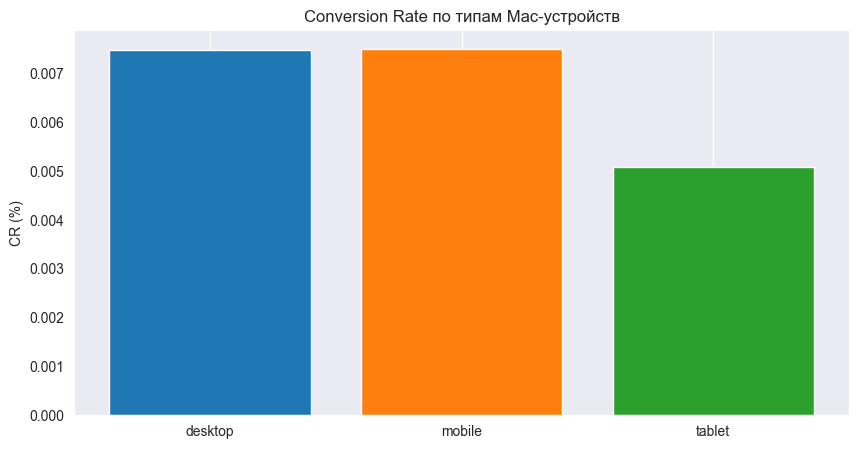

In [57]:
moscow_device_category = moscow_data.groupby("device_category").agg(
    total_sessions=('session_id', 'nunique'),
    conversions=('is_conversion', 'sum'),
    cr=('is_conversion', 'mean')
).reset_index()
display(moscow_device_category)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(moscow_device_category['device_category'], moscow_device_category['cr'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Conversion Rate по типам Mac-устройств')
plt.ylabel('CR (%)')
plt.grid(axis='y')
plt.show()

Москвичи чаще конвертируются с мобильных устройств. Возможно, это связано с быстрым темпом московской жизни.

In [60]:
# Анализ страниц
page_analysis = moscow_data.groupby('hit_page_path').agg(
    page_views=('hit_number', 'count'),
    conversions=('is_conversion', 'sum'),
    cr=('is_conversion', 'mean')
).reset_index()

# Фильтрация и сортировка
top_page_analysis = page_analysis[
    (page_analysis['page_views'] > 100) &  # Исключаем редко посещаемые
    (~page_analysis['hit_page_path'].str.contains('admin|test', na=False))  # Исключаем техстраницы
    ].sort_values('cr', ascending=False).head(3)
top_page_analysis

,hit_page_path,page_views,conversions,cr
1151,localhost/cars/9e8864fd?rental_page=rental_car,148,52,0.351351
1137,localhost/cars/4791c8b2?rental_page=rental_car,150,36,0.240000
894,client.preprod.sberauto.com/cars/all/hyundai/solaris/b82590a3?rental_page=rental_car,186,42,0.225806


Страница с ID 9e8864fd — эталон для подражания. Возможно, стоит перенести её лучшие компоненты на другие страницы. Это повысит средний CR по Москве.